In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
import tensorflow.keras as keras
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except RuntimeError as e:
    print(e)
print(f'tf: {tf.__version__}, keras: {keras.__version__}')

tf: 2.8.0, keras: 2.8.0


In [5]:
# for managing all model metadata, use neptune.ai:
import neptune.new as neptune

In [6]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = 'plotly_white'

import sys
sys.path.insert(0, '..')
import ml_utils
import pose_utils
from pose_utils import DEG_TO_RAD
from pose_utils import RAD_TO_SCALED
from pose_utils import MAX_DEPTH
from pose_utils import METERS_TO_SCALED
from pose_utils import INTENSITY_TO_SCALED
model_prefix = 'model_relative_pose'

In [7]:
# tf_data_path = '/data/all_around_zones_3500_tf_data'
# tf_data_path = '/data/all_around_scout_4501_tf_data'
# tf_data_path = '/data/face_to_face_zones_2500_tf_data'
# tf_data_path = '/data/hopper_4500_tf_data'
tf_data_path = '/data/t_formation_zones_3500_tf_data'

In [8]:
ds_test = ml_utils.load_dataset(tf_data_path + '_test', compression='GZIP')

img shape: (480, 640, 4), found 4 channels
raw:   x = 0.25  , y = -0.60  , yaw = 0.11 
human: x = 6.32 m, y = -14.95 m, yaw = 20 deg


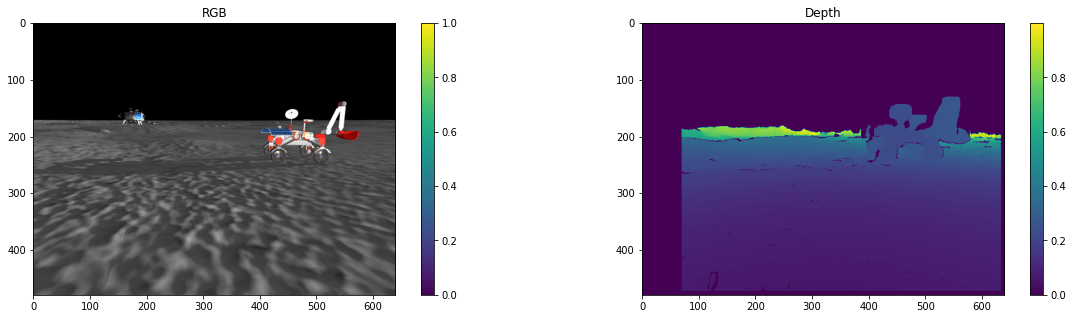

In [9]:
for image, label in ds_test.take(1):
    pose_utils.show_rgbd(image)
    x, y, yaw = label.numpy()
    print(f"raw:   x = {x:.2f}  , y = {y:.2f}  , yaw = {yaw:.2f} ")
    print(f"human: x = {x / METERS_TO_SCALED:.2f} m, y = {y / METERS_TO_SCALED:.2f} m, yaw = {yaw / RAD_TO_SCALED / DEG_TO_RAD:.0f} deg")

Load trained model

In [19]:
# PARAMS, run = ml_utils.get_neptune_latest_run(proj='ljburtz/relative-pose')
PARAMS, run = ml_utils.get_neptune_run(
    run_id='POSE-173', 
    proj='ljburtz/relative-pose'
)
PARAMS

https://app.neptune.ai/ljburtz/relative-pose/e/POSE-173
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


{'alpha': 0.1,
 'batch_size': 32,
 'beta': 0.03,
 'channels': 4,
 'description': 'trying cache',
 'epochs': 300,
 'height': 120,
 'patience': 4,
 'pool_size': 2,
 'width': 160}

In [20]:
run["model/model_end"].download('/tmp/')
run[f'model/{model_prefix}_weights'].download('/tmp/')
run[f'model/{model_prefix}_config'].download('/tmp/')

In [21]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.


All 3 operations synced, thanks for waiting!


option 1: Load full model (e.g to resume training): demerit: need to re-create the custom objects

In [22]:
batch_size = PARAMS['batch_size']
epochs = PARAMS['epochs']
alpha = PARAMS['alpha']
beta = PARAMS['beta']
buffer_size = 32

def pose_loss(y_true, y_pred):
    pose_loss = \
        ml_utils.distance_loss(y_true, y_pred) +  \
        alpha * ml_utils.theta_loss(y_true, y_pred) + \
        beta * ml_utils.orientation_loss(y_true, y_pred)
    return pose_loss

def theta_loss(y_true, y_pred):
    return alpha * ml_utils.theta_loss(y_true, y_pred)

def orientation_loss(y_true, y_pred):
    return beta * ml_utils.orientation_loss(y_true, y_pred)

In [23]:
custom_objects = {
    'distance_loss': ml_utils.distance_loss,        # intermediate loss, for tuning alpha and beta, 
    'theta_loss': theta_loss,                       # intermediate loss, for tuning alpha and beta
    'orientation_loss': orientation_loss,           # intermediate loss, for tuning alpha and beta
    'distance_diff': ml_utils.distance_diff,        # intermediate errors: human understandable
    'theta_diff': ml_utils.theta_diff,              # intermediate errors: human understandable
    'orientation_diff': ml_utils.orientation_diff,  # intermediate errors: human understandable
    'pose_loss': pose_loss
}

In [24]:
full_model = ml_utils.get_keras_model_full(custom_objects, '/tmp/model_end.h5', compiled=True)

option 2: Load just the model architecture and weights (e.g for inference)

In [10]:
inference_model = ml_utils.get_keras_model_inference(
    config_path='/tmp/' + model_prefix + '_config.json',
    weigths_path='/tmp/' + model_prefix + '_weights.h5'
)

## Time for inference!

In [11]:
# batch_size = PARAMS['batch_size']
batch_size = 12
buffer_size = 10
ds_test_b = ds_test.batch(batch_size, drop_remainder=True)
ds_test_b = ds_test_b.prefetch(buffer_size)

option 1 : full model

In [25]:
results = full_model.evaluate(ds_test_b)
print("test loss, test metrics:", results)

20/20 [==============================] - 3s 117ms/step - loss: 2.4699e-04 - distance_loss: 8.1310e-05 - theta_loss: 1.1224e-04 - orientation_loss: 5.3438e-05 - distance_diff: 0.1745 - theta_diff: 4.5820 - orientation_diff: 5.7738
test loss, test metrics: [0.0002469892497174442, 8.131007052725181e-05, 0.0001122411122196354, 5.343810698832385e-05, 0.1744575947523117, 4.5819783210754395, 5.7737836837768555]


In [30]:
n_pred = 100
d_true, theta_true, yaw_true, d_list, theta_list, yaw_list = ml_utils.predict_and_scale(
    full_model,
    ds_test,
    ds_test_b,
    n_pred,
    batch_size
)

In [33]:
fig = pose_utils.compare_each_output( 
    d_true, theta_true, yaw_true, 
    d_list, theta_list, yaw_list,
    subset=50
)
fig

In [32]:
fig = pose_utils.compare_optical_poses(
    d_true, theta_true, yaw_true, 
    d_list, theta_list, yaw_list,    
    # footprint='small_scout_1', 
    footprint='small_excavator_1', 
#     footprint='hopper',
    yaw_viz_offset=np.pi/2.
)
fig

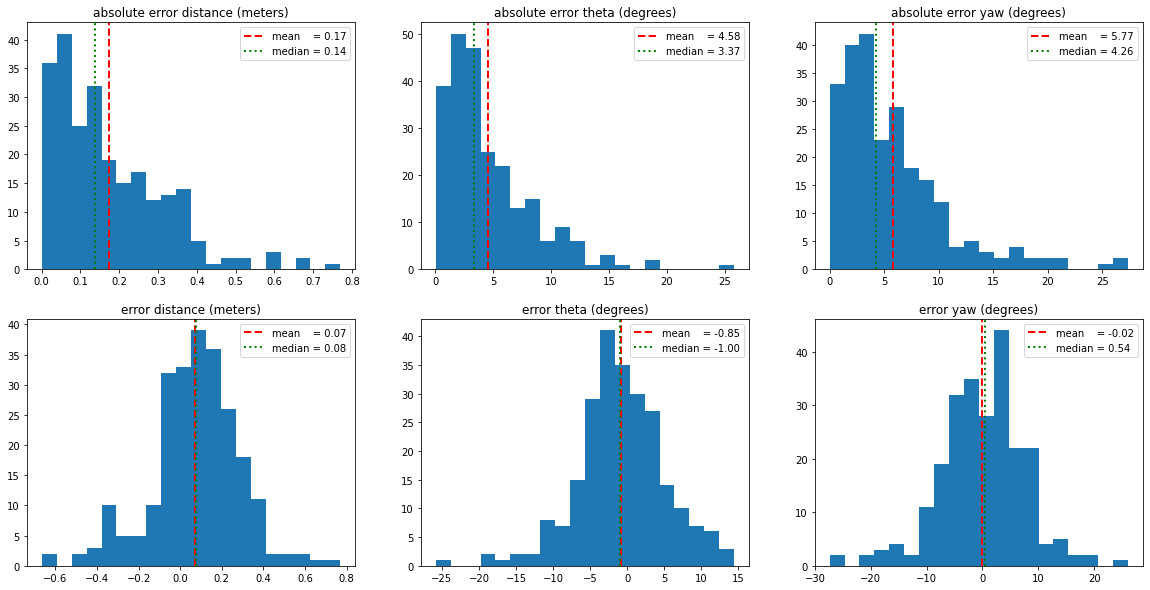

In [31]:
pose_utils.hist_errors(
    d_true, theta_true, yaw_true, 
    d_list, theta_list, yaw_list
);

Option2: For fast, single image at a time inference, do not use the .predict() function. instead pass the input data directly to the model (wrapped in a tf.function)

Example:

In [13]:
# prepare input images with propper shape
img_list = []
for img, label in ds_test.take(64):
    img = np.expand_dims(img, axis=0)
    img_list.append(img)

In [14]:
# wrap the model and make sure training is turned off
@tf.function
def serve(x):
    return inference_model(x, training=False)

In [15]:
%%time
# fast inference on each image, one at a time
# note that the first call needs warmup (so it's slow)
serve(img_list[62])

CPU times: user 164 ms, sys: 0 ns, total: 164 ms
Wall time: 163 ms


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.23317583, -0.48475325,  0.01020576]], dtype=float32)>

In [17]:
%%time
# fast inference on each image, one at a time
serve(img_list[63])

CPU times: user 2.37 ms, sys: 0 ns, total: 2.37 ms
Wall time: 2.01 ms


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.05658574, -0.5579037 ,  0.05439612]], dtype=float32)>

In [18]:
%%time
# fast inference on each image, one at a time
for img in img_list[:50]:
    serve(img)

CPU times: user 82.2 ms, sys: 6.39 ms, total: 88.6 ms
Wall time: 86.1 ms


Evaluate on the test set

In [12]:
n_pred = 10
d_true, theta_true, yaw_true, d_list, theta_list, yaw_list = ml_utils.predict_and_scale(
    inference_model,
    ds_test,
    ds_test_b,
    n_pred,
    batch_size
)

In [34]:
fig = pose_utils.compare_each_output( 
    d_true, theta_true, yaw_true, 
    d_list, theta_list, yaw_list,
    subset=50
)
fig

In [15]:
fig = pose_utils.compare_optical_poses(
    d_true, theta_true, yaw_true, 
    d_list, theta_list, yaw_list, 
    # footprint='small_scout_1', 
    footprint='small_excavator_1', 
#     footprint='hopper',
    yaw_viz_offset=np.pi/2.
)
fig

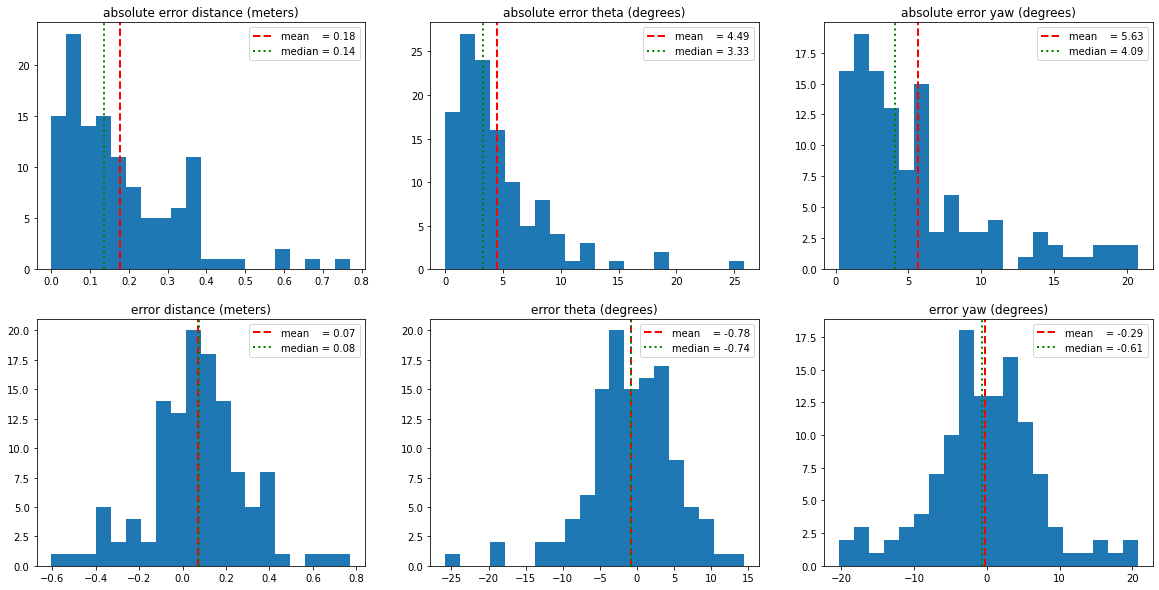

In [13]:
pose_utils.hist_errors(
    d_true, theta_true, yaw_true, 
    d_list, theta_list, yaw_list
);